In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/

/content/drive/MyDrive


In [3]:
!git clone https://github.com/jr2021/GA_feature_synergy.git

Cloning into 'GA_feature_synergy'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 80 (delta 6), reused 71 (delta 3), pack-reused 0
Unpacking objects: 100% (80/80), done.


In [6]:
cd /content/drive/MyDrive/GA_feature_synergy/demo

/content/drive/MyDrive/GA_feature_synergy/demo


In [7]:
import src.initialisation as init
import src.recombination as rec
import src.mutation as mut
import src.evaluation as eva
from src.statistics import Statistics
import src.selection as sel

from sklearn.datasets import *

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

import IPython.display as ipy
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In this notebook, we preview our genetic approach for feature synergy on scikit-learn's classic Boston data set, which defines 13 features related to median house price in 507 Boston datasets. The goal is to predict if the median house price is above or below the overall median.  For a higher-dimensional data set, scikit-learn's breast cancer data set can be loaded by replacing `load_boston()` with `load_breast_cancer()` in the cell below. In this case, lines 3 and 4 may be ommited.


In [8]:
raw = load_boston()
data = pd.DataFrame(raw.data, columns=raw.feature_names)
GTMEDV = [0 if x < np.median(raw.target) else 1 for x in raw.target]
data.insert(0, 'GTMEDV', GTMEDV) 
scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)
data.head()

,GTMEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,1.0,0.000000,0.18,0.067815,0.0,0.314815,0.577505,0.641607,0.269203,0.000000,0.208015,0.287234,1.000000,0.089680
1,1.0,0.000236,0.00,0.242302,0.0,0.172840,0.547998,0.782698,0.348962,0.043478,0.104962,0.553191,1.000000,0.204470
2,1.0,0.000236,0.00,0.242302,0.0,0.172840,0.694386,0.599382,0.348962,0.043478,0.104962,0.553191,0.989737,0.063466
3,1.0,0.000293,0.00,0.063050,0.0,0.150206,0.658555,0.441813,0.448545,0.086957,0.066794,0.648936,0.994276,0.033389
4,1.0,0.000705,0.00,0.063050,0.0,0.150206,0.687105,0.528321,0.448545,0.086957,0.066794,0.648936,1.000000,0.099338


We run the Multi-Objective Genetic Algorithm (MOGA) for feature selection, using KNN to create testing models. After the algorithm has terminated, information about the run and the resulting population is available in the `stats` object, whose structure is defined in `statistics.py`.

In [ ]:
params = {'population_size': 64,
              'parents_size': 32,  # must be even
              'children_size': 32,
              'generations': 100,
              'mutation_rate': 1,
              'k_range': 30,
              'features': data.shape[1] - 1,
              'y': data.columns[0]}

stats = Statistics(params)
population = init.NSGA_II(params)
population = eva.NSGA_II(population, data, params)

prev_error, prev_size = np.array([individual['meta']['error'] for individual in population]).mean(), np.array([individual['meta']['size'] for individual in population]).mean()
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.subplots_adjust(wspace=0.5, hspace=0.5)
ax[0, 0].set_xlabel('Feature Number'), ax[0, 0].set_ylabel('Solution Number')
ax[1, 0].set_xlabel('Generation'), ax[1, 0].set_ylabel('Avg. Class. Error')
ax[1, 1].set_xlabel('Generation'), ax[1, 1].set_ylabel('Avg. Subset Size')

for generation in range(params['generations']):
    parents, fronts = sel.NSGA_II(population, params, params['population_size'])
    parents, children = rec.NSGA_II(parents, params)
    children = mut.flip(children, params)
    children = eva.NSGA_II(children, data, params)
    population, fronts = sel.NSGA_II(np.concatenate((population, children)), params, params['population_size'])
    # population = np.concatenate((parents, children))  # population, fronts = sel.NSGA_II(np.concatenate((population, children)), params)

    stats.update_dynamic(population, generation)

    ax[0, 0].imshow(X=[individual['data'] for individual in population], aspect='auto', interpolation='none', origin='lower')
    ax[0, 1].clear()
    ax[0, 1].set_xlabel('Classification Error'), ax[0, 1].set_ylabel('Feature Subset Size')
    ax[0, 1].scatter(x=[individual['meta']['error'] for individual in population], y=[individual['meta']['size'] for individual in population], alpha=0.5, color='black')
    ax[1, 0].plot([generation - 1, generation], [prev_error, np.array([individual['meta']['error'] for individual in population]).mean()], color='black')
    prev_error = np.array([individual['meta']['error'] for individual in population]).mean()
    ax[1, 1].plot([generation - 1, generation], [prev_size, np.array([individual['meta']['size'] for individual in population]).mean()], color='black')
    prev_size = np.array([individual['meta']['size'] for individual in population]).mean()

    ipy.clear_output(wait=True)
    ipy.display(plt.gcf())

stats.update_static(population)

ipy.clear_output(wait=True)

The unique feature subsets are collected from the Pareto front of the resulting population, and are available in the `unique_stats` object.

In [ ]:
fronts = sel.fast_nondominated_sort(stats.data['final']['pop'], stats.data['meta'])

In [ ]:
pareto_stats = Statistics({'population_size': len(fronts[0]),
                      'generations': 1,
                      'features': 13})
pareto_stats.update_dynamic(fronts[0], 1)
pareto_stats.update_static(fronts[0])

In [ ]:
uniques, __ = [], []

j = 0
for sol in pareto_stats.data['final']['pop']:
    unique = {'meta': {'error': sol['meta']['error'],
                       'size': sol['meta']['size'],
                       'k_value': sol['meta']['k_value']},
              'data': sol['data']}
    _ = {'meta': {'error': sol['meta']['error'],
                  'size': sol['meta']['size']},
         'data': sol['data']}
    
    if _ not in __:
        uniques.append(unique)
        __.append(_)

    
    print('analyzing solution: ' + str(j))
    ipy.clear_output(wait=True)
    j += 1

analyzing solution: 23


In [ ]:
unique_stats = Statistics({'population_size': len(uniques),
                      'generations': 1,
                      'features': data.shape[1] - 1})
unique_stats.update_dynamic(uniques, 1)
unique_stats.update_static(uniques)

The unique feature subsets on the Pareto front are evaluated using the metrics defined in Section 2.3 to derive the feature characteristics of feature importance and feature synergy.

In [ ]:
imp = np.zeros(13, dtype=float)

for sol in unique_stats.data['final']['pop']:
    for i in range(len(sol['data'])):
        imp[i] += sol['data'][i] * ((1 - sol['meta']['error']) / sol['meta']['size'])

imp = (imp - np.min(imp)) / np.ptp(imp)

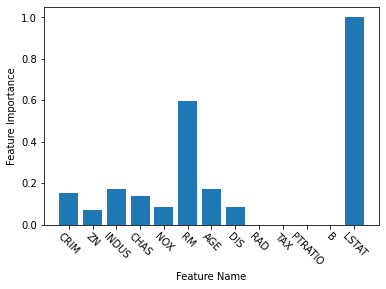

In [ ]:
plt.bar(x=data.columns[1:], height=imp)
plt.xticks(rotation=-45)
plt.xlabel('Feature Name'), plt.ylabel('Feature Importance')
plt.show()

In [ ]:
sorted_imp = {}

for i in range(len(data.columns[1:])):
    sorted_imp[data.columns[1:][i]] = imp[i]

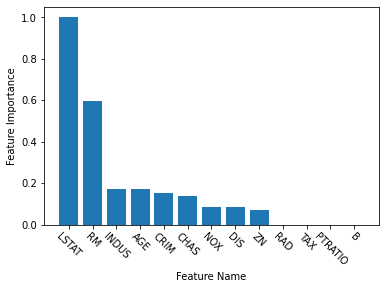

In [ ]:
plt.bar(x=sorted(sorted_imp, key=sorted_imp.get, reverse=True), height=sorted(sorted_imp.values(), reverse=True))
plt.xticks(rotation=-45)
plt.xlabel('Feature Name'), plt.ylabel('Feature Importance')
plt.show()

In [ ]:
interaction_matrix, accuracy_matrix = np.zeros((data.shape[1] - 1, data.shape[1] - 1), dtype=float), np.zeros((data.shape[1] - 1, data.shape[1] - 1), dtype=float)

for i in range(data.shape[1] - 1):
    for j in range(data.shape[1] - 1):
        if i == j:
            break

        both, left, right = 0, 0, 0
        for solution in unique_stats.data['final']['sols']:
            if solution[i] == 1 and solution[j] == 1:
                both += 1
            elif solution[i] == 1 and solution[j] == 0:
                left += 1
            elif solution[i] == 0 and solution[j] == 1:
                right += 1
        try:
            interaction_matrix[i][j] = both / (both + left + right)
            interaction_matrix[j][i] = both / (both + left + right)
        except:
            pass

        if interaction_matrix[i][j] != 0:
            total_scores = []
            for k in range(1,30):
                model, cross_validation = KNeighborsClassifier(k), StratifiedKFold(5, shuffle=True, random_state=1)
                split_scores = []
                X, y = data[[data.columns[i + 1], data.columns[j + 1]]], data[data.columns[0]]
                for m, n in cross_validation.split(X, y):
                    x_train, x_test, y_train, y_test = X.iloc[m], X.iloc[n], y.iloc[m], y.iloc[n]
                    model.fit(x_train, y_train)
                    split_scores.append(model.score(x_test, y_test))
                total_scores.append(np.array(split_scores).mean())
            
            accuracy_matrix[i][j] = interaction_matrix[i][j] * max(total_scores)  
            accuracy_matrix[j][i] = interaction_matrix[j][i] * max(total_scores)  

        print('analyzing interaction (' + str(i) + ', ' + str(j) + ')')
        ipy.clear_output(wait=True)

analyzing interaction (12, 11)


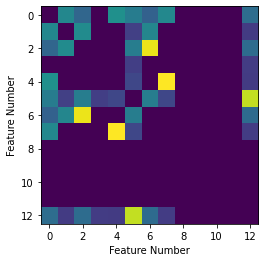

In [ ]:
plt.imshow(accuracy_matrix)
plt.xlabel('Feature Number'), plt.ylabel('Feature Number')
plt.show()


In the results, the feature pair LSTAT, the "proportion of adults without some high school education and proportion of male workers classified as laborers" and RM, the average number of rooms per dwelling, often emerges as highly synergistic (with the accuracy-factor). In the plot below a low value of LSTAT and a high value of RM is associated with high median housing prices, while a low value of RM and a high value of LSTAT is associated with low median housing prices.


In [ ]:
plt.scatter(x=data[data['GTMEDV'] == 0]['LSTAT'], y=data[data['GTMEDV'] == 0]['RM'])
plt.scatter(x=data[data['GTMEDV'] == 1]['LSTAT'], y=data[data['GTMEDV'] == 1]['RM'])
plt.xlabel('LSTAT'), plt.ylabel('RM')
plt.legend(['GTMEDV == 0', 'GTMEDV == 1'])
plt.show()

In [ ]:
def KNN_KFold(individual, data, params):
    model, cross_validation = KNeighborsClassifier(individual['meta']['k_value']), StratifiedKFold(5, shuffle=True, random_state=1)
    scores = []

    X, y = data.drop(columns=params['y']), data[params['y']]

    x = X.copy()
    for i in range(len(X.columns[:])):
        if individual['data'][i] == 0:
            x = x.drop(columns=X.columns[i])
        else:
            x[X.columns[i]] *= individual['data'][i]

    for i, j in cross_validation.split(x, y):
        x_train, x_test, y_train, y_test = x.iloc[i], x.iloc[j], y.iloc[i], y.iloc[j]
        model.fit(x_train, y_train)
        scores.append(model.score(x_test, y_test))

    return 1 - np.array(scores).mean()

print(KNN_KFold(uniques[0], data, params))

0.12846049310813434


In [ ]:
def KNN_KFold(individual, data, params):
    cross_validation = StratifiedKFold(5, shuffle=True, random_state=1)
    scores = []

    X, y = data.drop(columns=params['y']), data[params['y']]

    x = X.copy()
    for i in range(len(X.columns[:])):
        if individual['data'][i] == 0:
            x = x.drop(columns=X.columns[i])
        else:
            x[X.columns[i]] *= individual['data'][i]

    for i, j in cross_validation.split(x, y):
        model = KNeighborsClassifier(individual['meta']['k_value'])
        x_train, x_test, y_train, y_test = x.iloc[i], x.iloc[j], y.iloc[i], y.iloc[j]
        model.fit(x_train, y_train)
        scores.append(model.score(x_test, y_test))

    return 1 - np.array(scores).mean()

print(KNN_KFold(uniques[0], data, params))


0.12846049310813434
